In [2]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
import numpy as np
font1 = 20

bm.enable_x64()  # It's better to enable x64 when performing analysis
bm.set_platform('cpu')

bp.__version__

'2.4.6.post5'

In [6]:
class MorrisLecar(bp.dyn.NeuDyn):
    def __init__(self, size, neu_type=1, method='exp_auto', **kwargs):
        super(MorrisLecar, self).__init__(size=size, **kwargs)
        # parameters
        self.V_Ca = 120.
        self.g_Ca = 4.
        self.V_K = -84
        self.g_K = 8.
        self.V_leak = -60.
        self.g_leak = 2.
        self.C = 20.
        self.V1 = -1.2
        self.V2 = 18
        self.V_th = -15

        if neu_type == 1:
            self.V3 = 12.
            self.V4 = 17.
            self.phi = 2 / 30
        elif neu_type == 2:
            self.V3 = 2.
            self.V4 = 30
            self.phi = 0.04
        else:
            raise ValueError("type 类型只有 1 或者 2")

        # variables
        self.V = bm.Variable(-40 * bm.ones(self.num))
        self.W = bm.Variable(bm.zeros(self.num))
        self.Iext = bm.Variable(bm.zeros(self.num))
        self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))

        self.int_V = bp.odeint(self.dV, method=method)
        self.int_W = bp.odeint(self.dW, method=method)

    # functions
    def dV(self,V, t, W, Iext=0.):
        M_inf = (1 / 2) * (1 + bm.tanh((V - self.V1) / self.V2))
        I_Ca = self.g_Ca * M_inf * (V - self.V_Ca)
        I_K = self.g_K * W * (V - self.V_K)
        I_Leak = self.g_leak * (V - self.V_leak)
        dVdt = (-I_Ca - I_K - I_Leak + Iext) / self.C
        return dVdt

    def dW(self,W, t, V):
        tau_W = 1 / (self.phi * bm.cosh((V - self.V3) / (2 * self.V4)))
        W_inf = (1 / 2) * (1 + bm.tanh((V - self.V3) / self.V4))
        dWdt = (W_inf - W) / tau_W
        return dWdt



    def update(self):
        t,dt = bp.share['t'], bp.share['dt']
        V = self.int_V(self.V, t, self.W, self.Iext, dt)
        self.W.value = self.int_W(self.W, t, self.V, dt)
        self.spike.value = bm.logical_and(self.V < self.V_th, V >= self.V_th)
        self.V.value = V

        self.Iext[:] = 0.

  0%|          | 0/100000 [00:00<?, ?it/s]

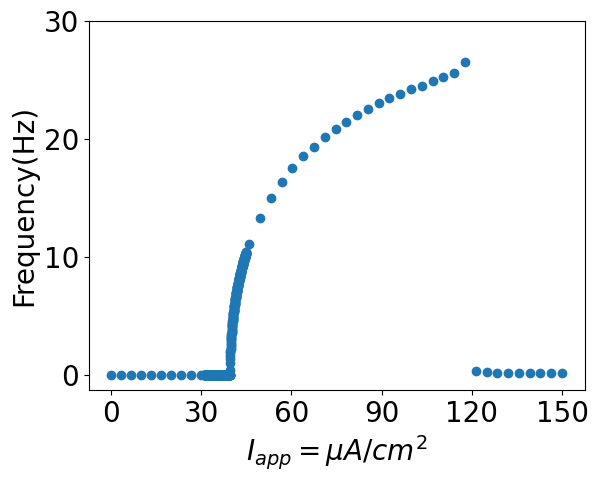

In [7]:
neuron_pre  = 10
neuron_mid  = 500
neuron_post = 30
neuron_num = neuron_pre + neuron_mid + neuron_post

time_interval = 10000
I_ext = bm.Variable(bm.concatenate([bm.linspace(0,30,neuron_pre),bm.linspace(31,45,neuron_mid),bm.linspace(46,150,neuron_post)]))

model = MorrisLecar(neuron_num,neu_type= 1)
runner = bp.DSRunner(model, monitors=['V', 'W','spike'], inputs=['Iext', I_ext])
runner.run(duration = time_interval)
spike = runner.mon.spike 
freq = bm.sum(spike,axis= 0)*1000/time_interval

plt.plot(I_ext, freq,'o')
plt.xlabel(r"$I_{app}=\mu A/cm^2$",fontsize= font1)
plt.ylabel("Frequency(Hz)",fontsize= font1)
plt.xticks(np.arange(0,153,30),fontsize=font1)
plt.yticks(np.arange(0,32,10),fontsize=font1)
# plt.savefig("figure/FI_{}.png".format(neuron_num),bbox_inches="tight")
plt.show()



  0%|          | 0/200000 [00:00<?, ?it/s]

(200000, 100)


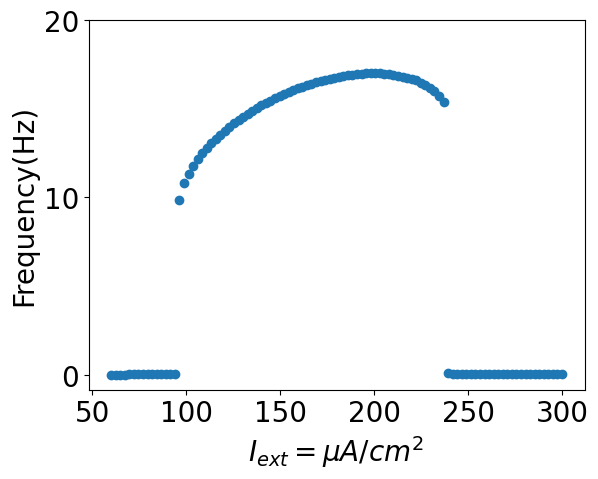

In [8]:

neuron_num =100
time_interval = 20000
I_ext = bm.Variable(bm.linspace(60,300,neuron_num))

model = MorrisLecar(neuron_num,neu_type= 2)
runner = bp.DSRunner(model, monitors=['V', 'W','spike'], inputs=['Iext', I_ext])
runner.run(duration = time_interval)
spike = runner.mon.spike 
print(bm.shape(spike))
freq = bm.sum(spike,axis= 0)*1000/time_interval

plt.plot(I_ext, freq,'o')
plt.xlabel(r"$I_{ext}=\mu A/cm^2$",fontsize= font1)
plt.ylabel("Frequency(Hz)",fontsize= font1)
plt.xticks(np.arange(50,303,50),fontsize=font1)
plt.yticks(np.arange(0,22,10),fontsize=font1)
# plt.savefig("figure/FI_{}.png".format(neuron_num),bbox_inches="tight")
plt.show()